In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import glob
import numpy as np
import optics_rig as orig
from scipy.interpolate import interp1d
from scipy import signal as signal
from scipy.stats import gamma, burr12, triang, logistic, norm, skewnorm
from scipy.optimize import curve_fit

from iteration_utilities import flatten

import os
import glob
from scipy import optimize
import copy
import dill

import colorcet as cc
 
from scipy.integrate import trapz

from spikes_statistics import *



from fitter import Fitter, get_common_distributions, get_distributions

In [2]:
pd.options.display.max_columns = None # this is to see all columns of pandas dataframes

In [3]:
DDIL = '/Users/gdal/Dropbox/Project/PICCOLO/Cruise/Data/Optics_rig/Processed/'
DPLOTS = '/Users/gdal/Dropbox/Project/PICCOLO/Cruise/Data/Optics_rig/Plots/'
DWAP_EX = '/Users/gdal/Dropbox/Project/PICCOLO/Cruise/Data/Optics_rig/WAP_Extracted/'


## Check typical descent speed 

In [4]:
fn = DDIL + '20240210.dil'
dil = orig.load_dill(fn)

In [5]:
# dil.keys()

In [6]:
# dil['ctd'].plot(y='pres', xlim=[0, 1e6], figsize=[10,2])
# plt.grid()

In [7]:
# compute descent speed in cm/s
i100 = np.where(dil['ctd']['pres'] >= 100)[0][0]
i300 = np.where(dil['ctd']['pres'] >= 300)[0][0]
print(str(np.round((dil['ctd']['pres'].values[i300]-dil['ctd']['pres'].values[i100])*100/((dil['ctd'].index[i300]-dil['ctd'].index[i100])/1000),2)) + " cm/s")

39.91 cm/s


In [8]:
fns = np.sort(glob.glob(DDIL + '*.dil'))

In [9]:
fn = fns[10]
fn

'/Users/gdal/Dropbox/Project/PICCOLO/Cruise/Data/Optics_rig/Processed/20240208.dil'

## Read dil file

In [10]:
dil = orig.load_dill(fn)

## Create RBR dataframe with re-zeroed index

In [11]:
rbr = dil['rbr']
# rbr.describe()

<Axes: xlabel='msec'>

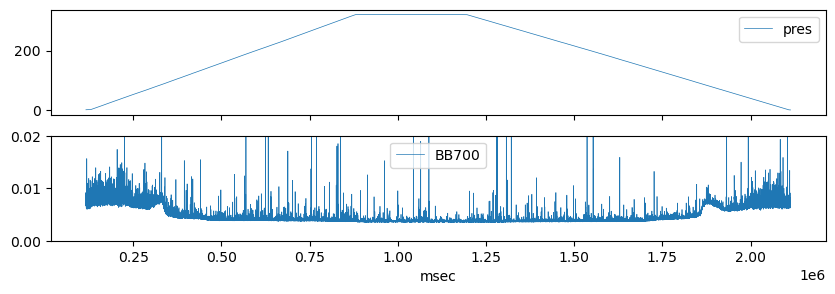

In [12]:
fig, ax = plt.subplots(2,1, figsize=[10,3], sharex=True)
rbr.plot(y='pres', lw=0.5, ax=ax[0])
rbr.plot(y='BB700', lw=0.5, ax=ax[1], ylim=[0, 0.02])

## Extract descending profile

In [13]:
imaxpres = np.where( rbr['pres'] >= rbr['pres'].max()-5 )[0][0]
iminpres = np.where( rbr['pres'] >= 5 )[0][0]

rbr = rbr.iloc[iminpres:imaxpres]
rbr['msec_rbr'] = rbr['msec_rbr'].values - rbr['msec_rbr'].values[0] # compute values for new index
rbr.set_index('msec_rbr', inplace=True) # reset index


/var/folders/98/ls269b9j6jq4z03kb9n9hxj40000gn/T/ipykernel_54161/2534102867.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rbr['msec_rbr'] = rbr['msec_rbr'].values - rbr['msec_rbr'].values[0] # compute values for new index


## Estimate descent rate

In [14]:
print(f"~{np.median(np.diff(rbr['pres']) / np.diff(rbr.index)) * 1000 * 100:4.1f} cm/sec")

~42.8 cm/sec


<Axes: xlabel='msec_rbr'>

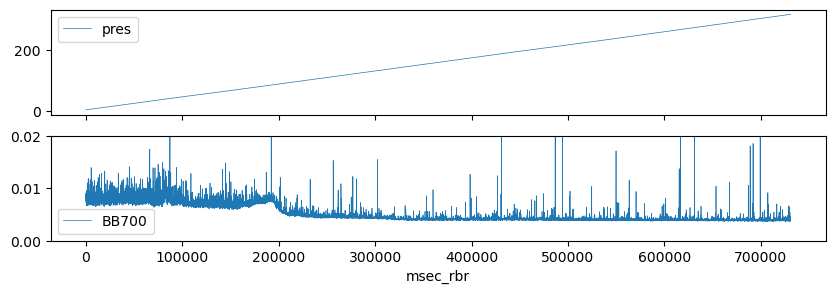

In [15]:
fig, ax = plt.subplots(2,1, figsize=[10,3], sharex=True)
rbr.plot(y='pres', lw=0.5, ax=ax[0])
rbr.plot(y='BB700', lw=0.5, ax=ax[1], ylim=[0, 0.02])

### Estimate profile sampling rate in 1/seconds

In [16]:
sampling_rate = np.round(1/np.nanmedian(np.diff(rbr.index)) * 1000)  # [sample/sec]
print(str(sampling_rate) + ' samples/second')

32.0 samples/second


## Estimates baseline and spikes for entire descending profile

### Define bin size in seconds

In [17]:
dt = 40 # [sec]  Note: for a typical ascent rate of 10 cm/s, this is dt*10 cm or dt/10 m

### Define bins for histogram

In [18]:
N_bins = int(25/40*dt) # for one 40-sec section of a profile I had estimated that 25 bins was a reasonable number, so now I apply this factor to all sections
print('number of bins ' + str(N_bins))

bins = np.linspace(-6, -2, N_bins)

number of bins 25


## Divide profile in time bins

In [19]:
rbr = create_bin_index(rbr, dt)

/Users/gdal/Dropbox/Project/PICCOLO/Cruise/Data/Source/PSD_mode/spikes_statistics.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rbr['bin'] = np.floor(rbr.index.values/(1000*dt))


## Create dataframe for binned results

In [20]:
cols = np.asarray(['pres', 'baseline', 'p1', 'p16', 'p50', 'p84', 'p100', 'N_spikes'] + [f'{b:<-5.02f}' for b in bins]).flatten()
rbr_binned = pd.DataFrame(data=None, index=rbr.bin.unique(), columns=cols)
# rbr_binned

## Add pressures to bins

In [21]:
### Other way to bin profile
grs = with_pandas_groupby(np.mean, rbr['pres'], rbr['bin'])
binned_pres = []
for igr, gr in enumerate(grs):
    binned_pres.append(grs.get_group(igr).mean())
    
rbr_binned['pres'] = binned_pres

# Extract data from one bin

In [22]:
for ibin in np.unique(rbr['bin'].values):
    rbr_binned = get_binned_BB(rbr, int(ibin), rbr_binned, bins)

In [23]:
rbr_binned.head()

,pres,baseline,p1,p16,p50,p84,p100,N_spikes,-6.00,-5.83,-5.67,-5.50,-5.33,-5.17,-5.00,-4.83,-4.67,-4.50,-4.33,-4.17,-4.00,-3.83,-3.67,-3.50,-3.33,-3.17,-3.00,-2.83,-2.67,-2.50,-2.33,-2.17,-2.00
0.0,13.450493,0.007821,-4.949293,-3.965523,-3.299402,-2.743372,-2.326826,122,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,4.0,4.0,6.0,7.0,8.0,10.0,15.0,10.0,10.0,18.0,13.0,8.0,4.0,1.0,0.0
1.0,30.479420,0.00786,-5.411783,-3.812378,-3.176937,-2.623061,-2.096438,117,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,3.0,1.0,3.0,3.0,3.0,5.0,8.0,11.0,17.0,13.0,12.0,10.0,15.0,4.0,3.0,1.0
2.0,47.410104,0.007371,-4.970685,-3.773203,-3.136518,-2.706095,-1.944896,188,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,1.0,3.0,4.0,8.0,6.0,12.0,17.0,11.0,22.0,28.0,15.0,29.0,16.0,5.0,5.0,0.0
3.0,63.962540,0.006725,-5.327408,-4.0234,-3.237674,-2.830506,-2.138837,206,1.0,0.0,0.0,0.0,1.0,2.0,2.0,0.0,3.0,2.0,6.0,9.0,8.0,9.0,15.0,18.0,18.0,19.0,31.0,28.0,16.0,8.0,5.0,4.0,1.0
4.0,80.760657,0.007319,-5.236219,-3.954163,-3.291463,-2.556335,-0.857891,63,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,1.0,1.0,4.0,4.0,4.0,7.0,4.0,9.0,4.0,4.0,5.0,3.0,2.0,1.0,0.0


# Plot binned data

## Plot histograms of log-spikes

In [24]:
N_time_bins = np.unique(rbr['bin'].values).size

In [25]:
delta_bin = np.floor(np.median(np.diff(rbr_binned['pres'].values)))

Text(0.5, 0, 'Log BB spike')

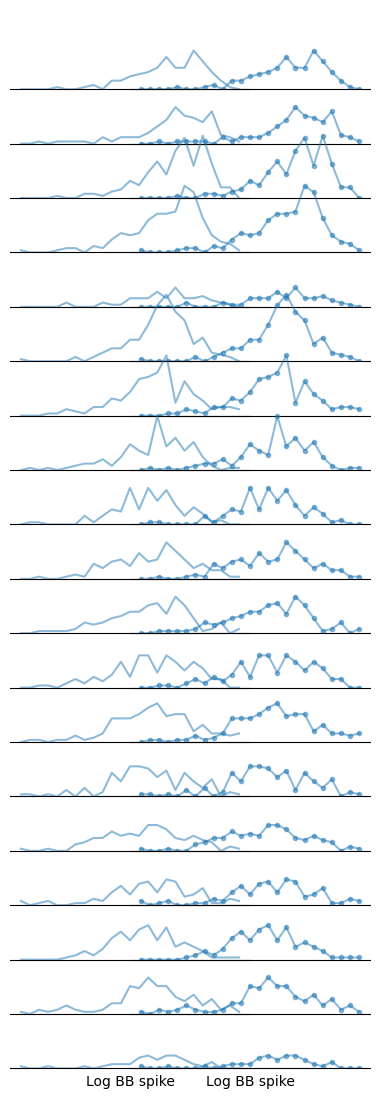

In [26]:
fig, ax = plt.subplots(N_time_bins, 2, figsize=[6,16], sharex=True, sharey=True)

for ibin in np.unique(rbr['bin'].values.astype(int)):
    # print(ibin)
    rbr_binned.iloc[ibin,8:].plot(ylim=[0, rbr_binned.iloc[:,8:].values.max()*1.2], alpha=0.5, ax=ax[ibin, 0])   #title=str(rbr_binned.loc[ibin, 'pres']), 
    
    ax[ibin, 0].set_position([0.2,                               # left
                          0.06 - ibin * 0.02 * delta_bin/10,  # bottom
                          0.4,                                # width
                          0.05 ])                             # height

    ax[ibin, 0].set_facecolor('none')
    ax[ibin, 0].spines[['left', 'right', 'top']].set_visible(False)
    
    
    ax[ibin, 0].tick_params(
        axis='x',  # changes apply to the x-axis
        which='both',  # both major and minor ticks are affected
        bottom=False,  # ticks along the bottom edge are off
        top=False,  # ticks along the top edge are off
        labelbottom=False
    )
    ax[ibin, 0].tick_params(
        axis='y',  # changes apply to the x-axis
        which='both',  # both major and minor ticks are affected
        left=False,  # ticks along the bottom edge are off
        top=False,  # ticks along the top edge are off
        labelleft=False
    )

    
ax[ibin, 0].set_xlabel('Log BB spike')







for ibin in np.unique(rbr['bin'].values.astype(int)):

    rbr_binned.iloc[ibin,8:].plot(marker='.', ylim=[0, rbr_binned.iloc[:,8:].values.max()*1.2], alpha=0.5, ax=ax[ibin, 1])   #title=str(rbr_binned.loc[ibin, 'pres']), 
    
    ax[ibin, 1].set_position([0.4,                               # left
                          0.06 - ibin * 0.02 * delta_bin/10,  # bottom
                          0.4,                                # width
                          0.05 ])                             # height

    ax[ibin, 1].set_facecolor('none')
    ax[ibin, 1].spines[['left', 'right', 'top']].set_visible(False)
    
    
    ax[ibin, 1].tick_params(
        axis='x',  # changes apply to the x-axis
        which='both',  # both major and minor ticks are affected
        bottom=False,  # ticks along the bottom edge are off
        top=False,  # ticks along the top edge are off
        labelbottom=False
    )
    ax[ibin, 1].tick_params(
        axis='y',  # changes apply to the x-axis
        which='both',  # both major and minor ticks are affected
        left=False,  # ticks along the bottom edge are off
        top=False,  # ticks along the top edge are off
        labelleft=False
    )

    
ax[ibin, 1].set_xlabel('Log BB spike')

## Plot percentiles of log-spikes

In [27]:
# fig, ax = plt.subplots(N_time_bins, 1, figsize=[2,16], sharex=True, sharey=True)

# for ibin in np.unique(rbr['bin'].values.astype(int)):
#     # print(ibin)
#     rbr_binned.iloc[ibin,8:].plot(ax=ax[ibin], ylim=[0, rbr_binned.iloc[:,8:].values.max()*1.2], alpha=0.5)   #title=str(rbr_binned.loc[ibin, 'pres']), 
    
#     ax[ibin].set_position([0.2,                               # left
#                           0.06 - ibin * 0.02 * delta_bin/10,  # bottom
#                           0.8,                                # width
#                           0.05 ])                             # height

#     ax[ibin].set_facecolor('none')
#     ax[ibin].spines[['left', 'right', 'top']].set_visible(False)
    
    
#     ax[ibin].tick_params(
#         axis='x',  # changes apply to the x-axis
#         which='both',  # both major and minor ticks are affected
#         bottom=False,  # ticks along the bottom edge are off
#         top=False,  # ticks along the top edge are off
#         labelbottom=False
#     )
#     ax[ibin].tick_params(
#         axis='y',  # changes apply to the x-axis
#         which='both',  # both major and minor ticks are affected
#         left=False,  # ticks along the bottom edge are off
#         top=False,  # ticks along the top edge are off
#         labelleft=False
#     )

    
# ax[ibin].set_xlabel('Log BB spike')

In [28]:
time_bin = 0

rbr_smpl = rbr.loc[rbr['bin']==time_bin]

## Extract baseline

rbr_binned.loc[time_bin, 'baseline'] = np.nanpercentile(rbr_smpl['BB700'].values, 50)
# rbr_baseline

## Extract spikes and log-transform them
rbr_spikes = get_spikes(rbr_smpl['BB700'].values, METHOD='Nathan')
rbr_spikes_log = np.log10(rbr_spikes**0.5)  # this is proportional to DIAMETER

## Extract log-spike percentiles
prct_pos = np.asarray([1, 16, 50, 84, 100])
rbr_binned.iloc[time_bin, 2:7] = np.nanpercentile(rbr_spikes_log, prct_pos)

## Compute how many spikes
# compute how many spikes after removing nans
rbr_binned.loc[time_bin, 'N_spikes'] = len(rbr_spikes_log[~np.isnan(rbr_spikes_log)])

# Extract histogram
tmp = function_hist(rbr_spikes_log, np.insert(bins, 0, -7))
rbr_binned.iloc[time_bin, 8:] = tmp[0]

## Plot spikes

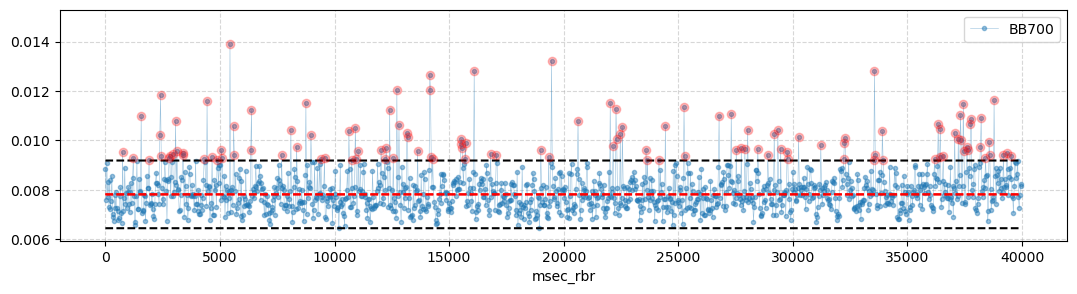

In [29]:
fig, ax = plt.subplots()

rbr_smpl.plot(y='BB700', lw=0.4, marker='o', markersize=3, figsize=[13,3], ylim=[rbr_smpl['BB700'].min() - 0.0005, np.percentile(rbr_smpl['BB700'], 100)*1.1], alpha=0.45, ax=ax)

ax.plot(rbr_smpl.index,  np.median(rbr_smpl['BB700']) * np.ones(rbr_smpl['BB700'].index.size), 'r--')
ax.plot(rbr_smpl.index,  ( np.median(rbr_smpl['BB700']) + ( np.median(rbr_smpl['BB700']) - np.min(rbr_smpl['BB700']) ) ) * np.ones(rbr_smpl.index.size), 'k--')
ax.plot(rbr_smpl.index,  np.min(rbr_smpl['BB700']) * np.ones(rbr_smpl.index.size), 'k--')

ax.plot(rbr_smpl.index,  np.median(rbr_smpl['BB700']) * np.ones(rbr_smpl.index.size), 'r--')

ispikes = np.where(rbr_spikes>0)[0]
ax.plot(rbr_smpl.iloc[ispikes].index,  rbr_smpl.iloc[ispikes]['BB700'], lw=0, marker='o', markersize=6, c='r', alpha=0.25)

ax.grid(ls='--', alpha=0.5)

Text(0.5, 0, 'S_{G} corrected')

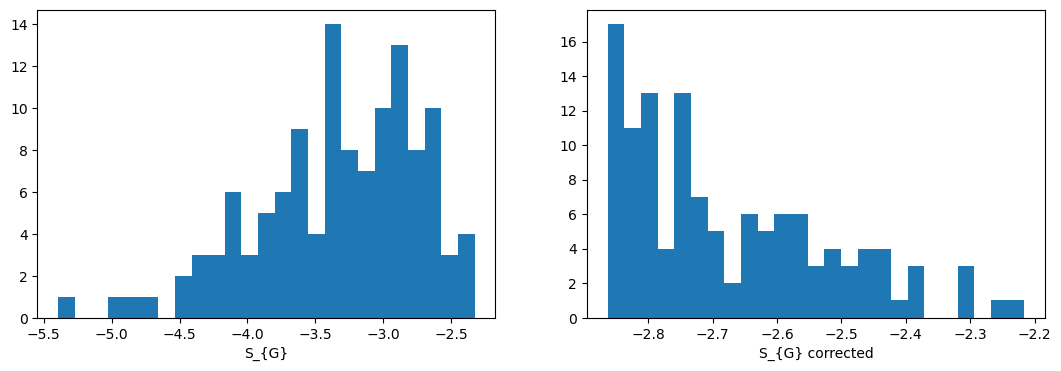

In [34]:
fig, ax = plt.subplots(1,2, figsize=[13,4])

rbr_spikes_G = get_spikes(rbr_smpl['BB700'].values, METHOD='grg')
rbr_spikes_log_G = np.log10(rbr_spikes_G)  

tmp_h = ax[0].hist(rbr_spikes_log_G, N_bins, cumulative=False, density=False)
ax[0].set_xlabel(r'S_{G}')


rbr_spikes_N = get_spikes(rbr_smpl['BB700'].values, METHOD='Nathan')
rbr_spikes_log_N = np.log10(rbr_spikes_N)  
rbr_spikes_log_N = rbr_spikes_log_N[~np.isnan(rbr_spikes_log_N)]

noise = np.nanmedian(rbr_smpl['BB700']) - np.nanmin(rbr_smpl['BB700'])
rbr_spikes_log_N2G = rbr_spikes_log_N + np.log10(1 - noise / (10**rbr_spikes_log_N))

# tmp_h = ax[1].hist(rbr_spikes_log_N, N_bins, cumulative=False, density=False)
# ax[1].set_xlabel(r'S_{N}')


rbr_spikes_log_G2N = np.log10(10**rbr_spikes_log_G + noise )

tmp_h = ax[1].hist(rbr_spikes_log_G2N, N_bins, cumulative=False, density=False)
ax[1].set_xlabel(r'S_{G} corrected')


### Former doubt
To compute the spikes, if we subtract the median value of the time bin, then we will have negative values in the resulting spikes which will prevent us from log transfomring the spikes.

Do we just add a constant value (that must be higher than the minimum of `rbr_smpl - np.median(rbr_smpl)` ?

In [31]:
# constant = 0.01
# rbr_spikes = rbr_smpl - np.median(rbr_smpl) + constant
# rbr_log_spikes = np.log10(rbr_spikes)

# fig, ax = plt.subplots()

# rbr_log_spikes.plot(lw=0.1, marker='.', markersize=2, figsize=[13,2], ax=ax)
# ax.grid(ls='--')

I don't think so, because  this would just shift the whole log-transformed dataset by a given amount, but would not isolate the spikes.

To isolate the spikes we really need to drop some of the data. 

It's easy to drop those below the median, but how do we remove those above the median?

IDEA: perhaps we could estimate the "half of the noise of the sensor" by computing the difference between `median(BB700)` and `min(BB700)` value and then removing this half noise from the the data above the median.

In [32]:
N_time_bins

19

## Fit distribution

In [44]:
for time_bin in range(N_time_bins):

    # extract data for this bin
    rbr_smpl = rbr.loc[rbr['bin']==time_bin]

    ## Extract baseline

    rbr_binned.loc[time_bin, 'baseline'] = np.nanpercentile(rbr_smpl['BB700'].values, 50)
    # rbr_baseline

    ## Extract spikes and log-transform them
    rbr_spikes = get_spikes(rbr_smpl['BB700'].values);
    rbr_spikes_log = np.log10(rbr_spikes)


    y = rbr_spikes_log[~np.isnan(rbr_spikes_log)]

    f = Fitter(y,
               distributions=[
                   'burr12',
                   # 'norm',
                   # 'logistic',
                   'triang',
                   'skewnorm',
               ],
               bins=bins,
               density=False,
               # distributions=get_distributions(),
               # timeout=60
              )
    f.fit()
    print(time_bin)
    print(f.summary(Nbest=3, plot=False))
    
    break

0
          sumsquare_error         aic         bic  kl_div  ks_statistic  \
skewnorm         0.147027  123.526929 -805.569109     inf      0.054048   
burr12           0.193568  118.681452 -767.213910     inf      0.053970   
triang           0.252352         inf -739.663817     inf      0.109661   

          ks_pvalue  
skewnorm   0.849058  
burr12     0.850252  
triang     0.098565  


In [34]:
f.summary?

Signature: f.summary(Nbest=5, lw=2, plot=True, method='sumsquare_error', clf=True)
Docstring: Plots the distribution of the data and Nbest distribution
File:      ~/miniconda3/envs/grg/lib/python3.9/site-packages/fitter/fitter.py
Type:      method

In [45]:
rbr_binned.iloc[0, 2:8]

p1         -4.949293
p16        -3.965523
p50        -3.299402
p84        -2.743372
p100       -2.326826
N_spikes         122
Name: 0.0, dtype: object

In [46]:
f.fitted_param['skewnorm']

(-6.010347617409856, -2.552425503601399, 0.9922718285509029)

In [47]:
c, loc, scale = f.fitted_param['triang']

In [48]:
c2, loc2, scale2 = f.fitted_param['skewnorm']
f.fitted_param['skewnorm']

(-6.010347617409856, -2.552425503601399, 0.9922718285509029)

In [ ]:
## compute pdf and cdf from parameters

x = np.linspace(-6, -1, 400)

# pdf_burr12 = burr12_pdf(x, c, d, scale, loc)
# # cdf_burr12 = burr12_cdf(x, c, d, scale, loc)
# pdf_logistic = logistic_pdf(x, scale, loc)
# cdf_logistic = logistic_cdf(x, scale, loc)



In [ ]:
# rbr_binned.iloc[-1]['N_spikes']

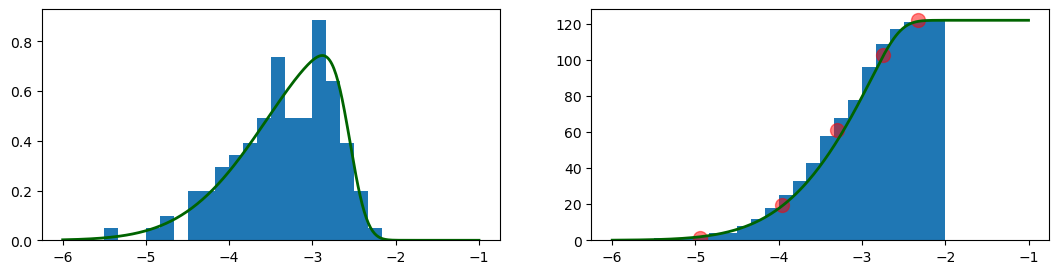

In [51]:
x = np.linspace(-6, -1, 400)



fig, ax = plt.subplots(1,2, figsize=[13,3])

ax[0].hist(rbr_spikes_log, bins=bins, 
                         density=True)

# density bool, default: False
# If True, draw and return a probability density: each bin will display the bin's raw count divided by 
# the total number of counts and the bin width (density = counts / (sum(counts) * np.diff(bins))), 
# so that the area under the histogram integrates to 1 (np.sum(density * np.diff(bins)) == 1).
# If stacked is also True, the sum of the histograms is normalized to 1.

ax[0].plot(x, skewnorm.pdf(x, c2, loc2, scale2), c='darkgreen', lw=2) 
# ax[0].plot(x, triang.pdf(x, c, loc, scale), c='r') 


ax[1].hist(rbr_spikes_log, bins=bins, cumulative=True)

ax[1].plot(rbr_binned.iloc[0,2:7], np.asarray([1, 16, 50, 84, 100]) / 100 * rbr_binned.iloc[0]['N_spikes'], 'ro-', ms=10, lw=0, alpha=.5)
# ax[1].plot(x, (cdf_logistic + 1) * N_spikes , c='k') 
# ax[1].plot(x, triang.cdf(x, c, loc, scale) * rbr_binned.iloc[-1]['N_spikes'], c='r') 
ax[1].plot(x, skewnorm.cdf(x, c2, loc2, scale2) * rbr_binned.iloc[0]['N_spikes'], c='darkgreen', lw=2) 


In [29]:
x2fit = rbr_binned.iloc[0,2:7].values
y2fit = np.asarray([1, 16, 50, 84, 100]) / 100 * rbr_binned.iloc[-1]['N_spikes']

In [32]:
x_ = rbr_binned.iloc[0, 2:7].values
y_ = np.asarray([1, 16, 50, 84, 100]) / 100 * rbr_binned.iloc[-1]['N_spikes']

f = lambda x_ ,c2, loc2, scale2: skewnorm(c2, loc2, scale2).cdf(x_)

c2, loc2, scale2 = curve_fit(f, x2fit, y2fit)[0]

/Users/gdal/miniconda3/envs/grg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [33]:
c2, loc2, scale2

(-129.65260954458608, -216.75434924097678, 71.11269457492129)

NameError: name 'c2' is not defined

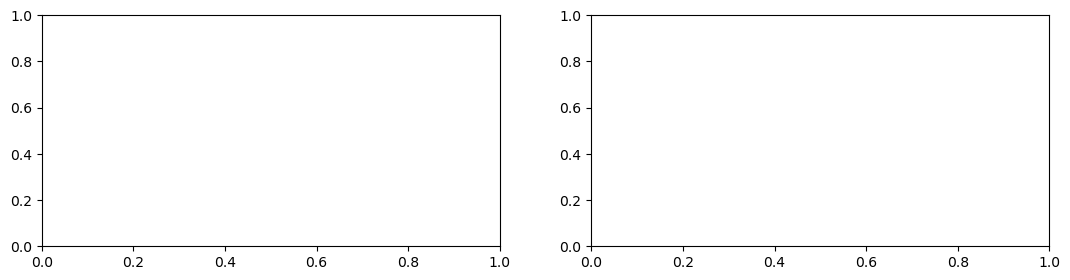

In [30]:
x = np.linspace(-6, -1, 400)

fig, ax = plt.subplots(1,2, figsize=[13,3])

# ax[0].hist(rbr_spikes_log, bins=bins, 
#                          density=True)

ax[0].plot(x, skewnorm.pdf(x, c2, loc2, scale2), c='darkgreen', lw=2) 


ax[1].hist(rbr_spikes_log, bins=bins, cumulative=True)
ax[1].plot(rbr_binned.iloc[-1,2:7], np.asarray([1, 16, 50, 84, 100]) / 100 * rbr_binned.iloc[-1]['N_spikes'], 'ro-', ms=10, lw=0, alpha=.5)
ax[1].plot(x, skewnorm.cdf(x, c2, loc2, scale2) * rbr_binned.iloc[-1]['N_spikes'], c='darkgreen', lw=2) 


In [269]:
data


array([-4.949293337012719, -3.965523198524306, -3.299401814028952,
       -2.7433722848531676, -2.3268263329130767], dtype=object)

# TO DO

## - Do we need to optimize which percentiles we want?
## - Test on several profiles: 
## ----- What is the best type of distribution?
## ----- Do we need 5 percentiles or could we use less (and thus free-up space for CHL spikes)?


# Problems to solve
## - How to compute spikes?
- grg: `sp_grg = raw - med - noise > 0`
- nathan: `sp_nat = raw - med > noise`
- In theory they are equivalent, IF we save `noise = med - min = percentile(Sp_grg, 0)`
- `log10(sp_grg) = log10(sp_nat) + log10(1 - noise/sp_nat)`
- `log10(sp_nat) = log10(10^{log10(sp_grg)} + noise)`
## - How to represent spike distribution? (it depends on answer to question above)
## - How to bin spikes in the sensor so that the float can bin them as well?